$$\begin{cases}
    y'' + \sin{y} = 0, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Это уравнение можно свести к системе

$$\begin{cases}
    y' = u \\
    u' = -\sin{y}, 0 \le x \le 3 \\
    y(0) = 0, y(3) = \pi
\end{cases}$$

Которая имеет первый интеграл

$$C(y, u) = u^2 - 2\cos{y}$$

Его и будем использовать для проверки точности решения

In [1]:
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from BVPlib import *
from math import *

def f(x : float, y : Vector, dy : float):
    return -sin(y)

def C(y : Vector):
    return y[1]*y[1] - 2*cos(y[0])

def show_result(N : int, us : list[Vector], h : float):
    xs = [h*k for k in range(N + 1)]
    fig = plt.figure(figsize=[6,8])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    fig.add_subplot(gs[0])
    plt.plot(xs, [us[k][0] for k in range(N + 1)])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(r"$y'' + \sin{y} = 0, y(0) = 0, y(3) = \pi$")
    ax = fig.add_subplot(gs[1])
    plt.plot(xs, [C(us[k]) - C(us[-1]) for k in range(N + 1)], "--", label="C(y(x), y'(x)) - C(y(3), y'(3))", color="orange")
    formatter = ScalarFormatter(useMathText=True, useOffset=False)
    ax.yaxis.set_major_formatter(formatter)
    plt.legend()

N = 1000
h = 3 / N

# Метод стрельбы

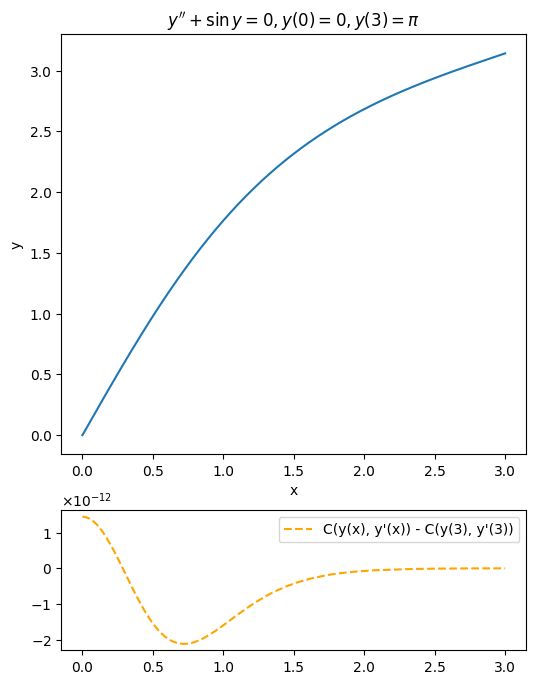

In [2]:
show_result(N, BVPSolver.solve_by_shooting_method(f, h, N, 0, pi), h)

# Метод квазилинеаризации Ньютона

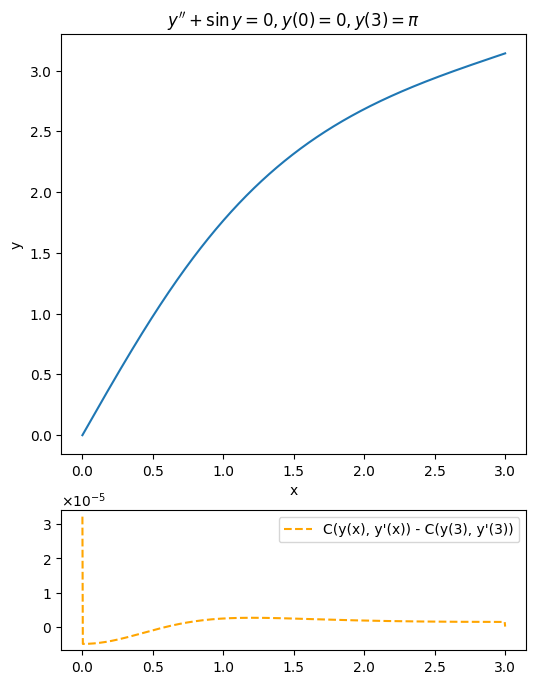

In [3]:
show_result(N, BVPSolver.solve_by_quasilinearization_method(f, h, N, 0, pi), h)